# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

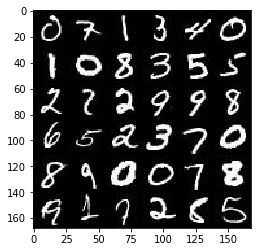

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

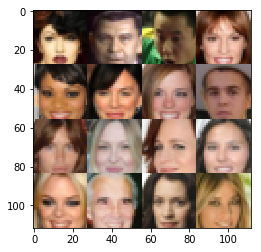

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,[None, image_width, image_height,image_channels], name='input_real')
    
    input_z = tf.placeholder(tf.float32, [None,z_dim], name='input_z')
    
    lr = tf.placeholder(tf.float32,name='lr')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha*x1, x1)
        relu1 = tf.nn.dropout(relu1,0.8)
        # 14*14*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2,0.8)
        # 7*7*128
        
        """
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3,0.8)
        # 7*7*256
        """
        
        flat = tf.reshape(relu2, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))

        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14*14*128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14*14*64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same', 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28*28*out_channel_dim
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, lr, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images, lr:learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses, samples
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 4.0105... Generator Loss: 0.0483
Epoch 1/2... Discriminator Loss: 2.5765... Generator Loss: 0.1556
Epoch 1/2... Discriminator Loss: 2.4736... Generator Loss: 0.2485
Epoch 1/2... Discriminator Loss: 1.9971... Generator Loss: 0.3218
Epoch 1/2... Discriminator Loss: 2.2229... Generator Loss: 0.5176
Epoch 1/2... Discriminator Loss: 1.5644... Generator Loss: 0.7863
Epoch 1/2... Discriminator Loss: 1.6774... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 1.1249
Epoch 1/2... Discriminator Loss: 0.8734... Generator Loss: 1.5449
Epoch 1/2... Discriminator Loss: 0.5698... Generator Loss: 1.9652


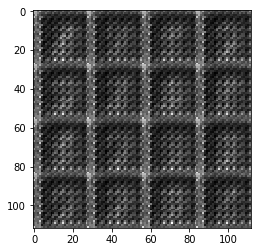

Epoch 1/2... Discriminator Loss: 1.9741... Generator Loss: 0.4018
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.9602
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 1.3079
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 1.4449... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 1.7379... Generator Loss: 0.5936
Epoch 1/2... Discriminator Loss: 1.4647... Generator Loss: 1.6599
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.4010
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 1.3730
Epoch 1/2... Discriminator Loss: 1.7688... Generator Loss: 0.4550


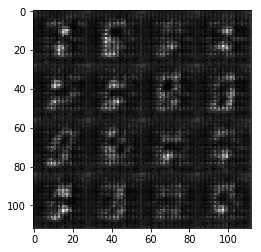

Epoch 1/2... Discriminator Loss: 1.5758... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 2.4147... Generator Loss: 0.3389
Epoch 1/2... Discriminator Loss: 2.2530... Generator Loss: 0.2700
Epoch 1/2... Discriminator Loss: 1.7172... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.8915
Epoch 1/2... Discriminator Loss: 1.7776... Generator Loss: 0.5748
Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 1.5381
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.5844... Generator Loss: 0.3795
Epoch 1/2... Discriminator Loss: 1.5957... Generator Loss: 1.2312


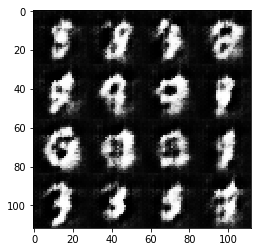

Epoch 1/2... Discriminator Loss: 2.0797... Generator Loss: 0.5255
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 1.2044
Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.5504... Generator Loss: 1.0171
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 1.5197
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.5122... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 1.8926... Generator Loss: 0.3237
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 0.9974


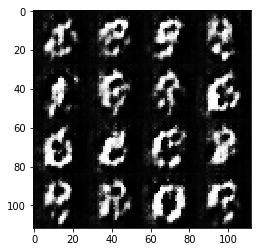

Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 1.0867
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 1.0193
Epoch 1/2... Discriminator Loss: 1.6938... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.5973... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 1.6342... Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 1.2598... Generator Loss: 1.3646
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.6894
Epoch 1/2... Discriminator Loss: 1.8863... Generator Loss: 0.6209


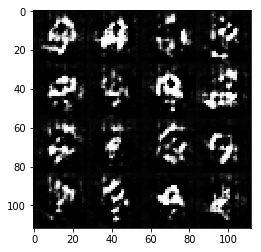

Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 1.7845... Generator Loss: 1.1952
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.7711
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 1.2931
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.9868
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.8187
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 2.0517... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.8896
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.8167


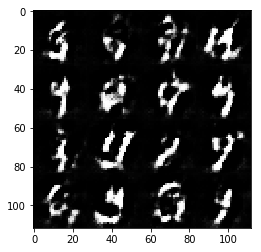

Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 0.8840
Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 1.4889
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.5322
Epoch 1/2... Discriminator Loss: 1.3227... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 1.5740... Generator Loss: 0.5452
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.4267... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.9195


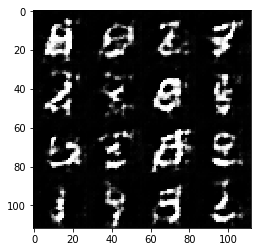

Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 1.5340... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 1.6958... Generator Loss: 0.5207
Epoch 1/2... Discriminator Loss: 1.9623... Generator Loss: 1.9648
Epoch 1/2... Discriminator Loss: 1.5707... Generator Loss: 1.2009
Epoch 1/2... Discriminator Loss: 1.5776... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 0.9505
Epoch 1/2... Discriminator Loss: 1.8467... Generator Loss: 0.3862
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.5961
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 1.0473


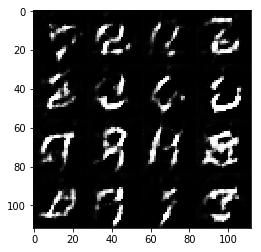

Epoch 1/2... Discriminator Loss: 1.5530... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.4561... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 1.6095... Generator Loss: 0.4750
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.5167
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 0.5328
Epoch 1/2... Discriminator Loss: 1.6144... Generator Loss: 1.1431
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.9044
Epoch 1/2... Discriminator Loss: 1.5247... Generator Loss: 0.6895
Epoch 1/2... Discriminator Loss: 1.5361... Generator Loss: 1.0072


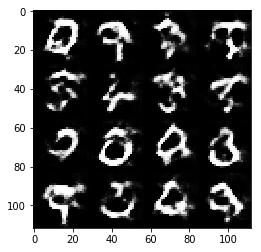

Epoch 1/2... Discriminator Loss: 1.6042... Generator Loss: 0.9863
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 0.8964
Epoch 2/2... Discriminator Loss: 1.7158... Generator Loss: 0.7068
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 1.1137
Epoch 2/2... Discriminator Loss: 1.5427... Generator Loss: 0.6895
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.7545
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 1.1294
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.7469


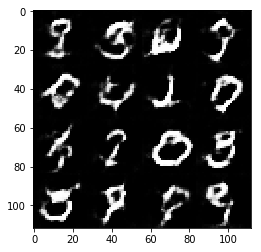

Epoch 2/2... Discriminator Loss: 1.3601... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 0.9603
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.6173
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 1.1695
Epoch 2/2... Discriminator Loss: 1.7196... Generator Loss: 0.4662
Epoch 2/2... Discriminator Loss: 1.4711... Generator Loss: 1.6242
Epoch 2/2... Discriminator Loss: 1.2407... Generator Loss: 0.8379
Epoch 2/2... Discriminator Loss: 1.4742... Generator Loss: 0.7280
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.8580
Epoch 2/2... Discriminator Loss: 1.4560... Generator Loss: 0.9052


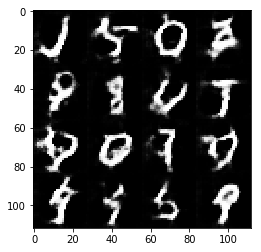

Epoch 2/2... Discriminator Loss: 1.4370... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.7845... Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 1.5695... Generator Loss: 0.6094
Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 1.5771... Generator Loss: 0.9083
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 0.5201
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 1.4946... Generator Loss: 0.4109
Epoch 2/2... Discriminator Loss: 1.4406... Generator Loss: 0.7782
Epoch 2/2... Discriminator Loss: 1.4839... Generator Loss: 0.7796


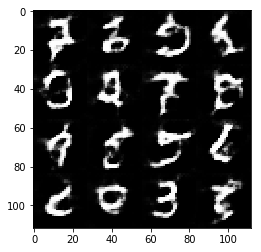

Epoch 2/2... Discriminator Loss: 1.4753... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 0.5122
Epoch 2/2... Discriminator Loss: 1.5383... Generator Loss: 0.7832
Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 0.6405
Epoch 2/2... Discriminator Loss: 1.5917... Generator Loss: 1.0098
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.5454... Generator Loss: 1.1117
Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.8634
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.7008
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.6814


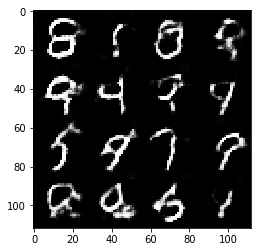

Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 0.8941
Epoch 2/2... Discriminator Loss: 1.5550... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 1.6900... Generator Loss: 0.7013
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.5618
Epoch 2/2... Discriminator Loss: 1.4943... Generator Loss: 0.8514
Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.8221
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 0.9143
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 1.4815
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 1.0369


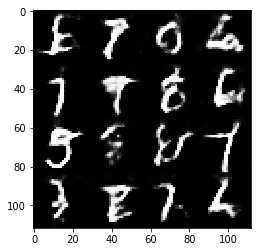

Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 1.1756
Epoch 2/2... Discriminator Loss: 1.6321... Generator Loss: 1.0881
Epoch 2/2... Discriminator Loss: 1.5951... Generator Loss: 0.8812
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.8688
Epoch 2/2... Discriminator Loss: 1.4594... Generator Loss: 0.9474
Epoch 2/2... Discriminator Loss: 1.2040... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 1.6031... Generator Loss: 0.7790
Epoch 2/2... Discriminator Loss: 1.4305... Generator Loss: 0.7375


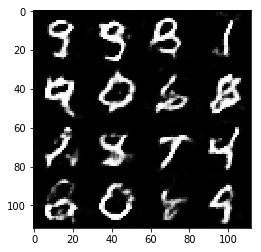

Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 0.4910
Epoch 2/2... Discriminator Loss: 1.5403... Generator Loss: 0.8936
Epoch 2/2... Discriminator Loss: 1.4893... Generator Loss: 0.6220
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 1.0811
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 1.1376
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 0.4423
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 1.3643
Epoch 2/2... Discriminator Loss: 1.4435... Generator Loss: 1.2540
Epoch 2/2... Discriminator Loss: 1.5235... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.9630


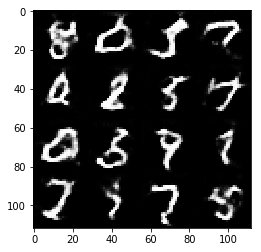

Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 1.0661
Epoch 2/2... Discriminator Loss: 1.3986... Generator Loss: 1.2458
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 1.4022
Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 0.8987
Epoch 2/2... Discriminator Loss: 1.4559... Generator Loss: 0.6737
Epoch 2/2... Discriminator Loss: 1.5079... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 1.4987... Generator Loss: 1.4939
Epoch 2/2... Discriminator Loss: 1.7453... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 1.4228... Generator Loss: 0.8500
Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 1.2392


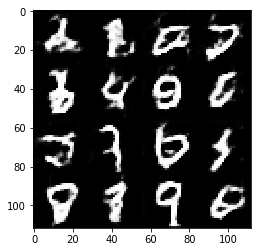

Epoch 2/2... Discriminator Loss: 1.4777... Generator Loss: 1.0275
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 0.8211
Epoch 2/2... Discriminator Loss: 1.5727... Generator Loss: 0.5084
Epoch 2/2... Discriminator Loss: 1.6252... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.4220... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 1.2766
Epoch 2/2... Discriminator Loss: 1.7229... Generator Loss: 0.7154
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.8802
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 0.8280


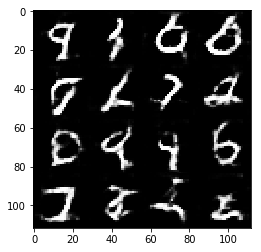

Epoch 2/2... Discriminator Loss: 1.4586... Generator Loss: 0.9689
Epoch 2/2... Discriminator Loss: 1.6107... Generator Loss: 0.5224
Epoch 2/2... Discriminator Loss: 1.5562... Generator Loss: 1.3523
Epoch 2/2... Discriminator Loss: 1.4999... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 1.4909... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 1.2765... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 1.5015... Generator Loss: 0.5925


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/5... Discriminator Loss: 4.6535... Generator Loss: 0.0324
Epoch 1/5... Discriminator Loss: 4.3126... Generator Loss: 0.0618
Epoch 1/5... Discriminator Loss: 3.3407... Generator Loss: 0.1486
Epoch 1/5... Discriminator Loss: 1.8627... Generator Loss: 0.6593
Epoch 1/5... Discriminator Loss: 2.6348... Generator Loss: 0.3536
Epoch 1/5... Discriminator Loss: 1.9423... Generator Loss: 0.3291
Epoch 1/5... Discriminator Loss: 1.4803... Generator Loss: 0.7227
Epoch 1/5... Discriminator Loss: 1.5076... Generator Loss: 0.5045
Epoch 1/5... Discriminator Loss: 1.3427... Generator Loss: 0.8244
Epoch 1/5... Discriminator Loss: 2.3107... Generator Loss: 0.9061


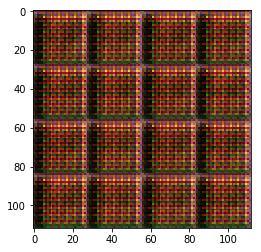

Epoch 1/5... Discriminator Loss: 1.2833... Generator Loss: 1.0515
Epoch 1/5... Discriminator Loss: 1.4025... Generator Loss: 0.7474
Epoch 1/5... Discriminator Loss: 1.2679... Generator Loss: 1.1617
Epoch 1/5... Discriminator Loss: 1.1362... Generator Loss: 1.1303
Epoch 1/5... Discriminator Loss: 1.1986... Generator Loss: 1.2378
Epoch 1/5... Discriminator Loss: 1.2935... Generator Loss: 1.0641
Epoch 1/5... Discriminator Loss: 1.0989... Generator Loss: 0.9123
Epoch 1/5... Discriminator Loss: 2.4883... Generator Loss: 0.1871
Epoch 1/5... Discriminator Loss: 1.5032... Generator Loss: 0.9404
Epoch 1/5... Discriminator Loss: 1.2943... Generator Loss: 1.1587


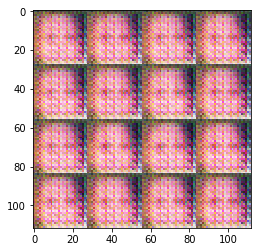

Epoch 1/5... Discriminator Loss: 1.3435... Generator Loss: 1.0705
Epoch 1/5... Discriminator Loss: 0.8418... Generator Loss: 1.6418
Epoch 1/5... Discriminator Loss: 0.9581... Generator Loss: 1.2959
Epoch 1/5... Discriminator Loss: 1.6747... Generator Loss: 1.9185
Epoch 1/5... Discriminator Loss: 0.7082... Generator Loss: 3.3881
Epoch 1/5... Discriminator Loss: 2.2903... Generator Loss: 0.6045
Epoch 1/5... Discriminator Loss: 1.7325... Generator Loss: 0.5251
Epoch 1/5... Discriminator Loss: 0.9875... Generator Loss: 1.3835
Epoch 1/5... Discriminator Loss: 1.2383... Generator Loss: 0.7483
Epoch 1/5... Discriminator Loss: 2.1505... Generator Loss: 0.3241


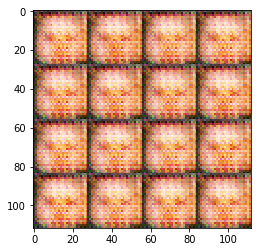

Epoch 1/5... Discriminator Loss: 0.7992... Generator Loss: 1.7090
Epoch 1/5... Discriminator Loss: 0.8449... Generator Loss: 1.4442
Epoch 1/5... Discriminator Loss: 1.3173... Generator Loss: 2.9742
Epoch 1/5... Discriminator Loss: 0.9449... Generator Loss: 1.0624
Epoch 1/5... Discriminator Loss: 0.5959... Generator Loss: 3.0691
Epoch 1/5... Discriminator Loss: 0.8198... Generator Loss: 1.1809
Epoch 1/5... Discriminator Loss: 0.8299... Generator Loss: 1.0111
Epoch 1/5... Discriminator Loss: 0.7026... Generator Loss: 2.0327
Epoch 1/5... Discriminator Loss: 1.0939... Generator Loss: 0.9081
Epoch 1/5... Discriminator Loss: 0.9865... Generator Loss: 1.9139


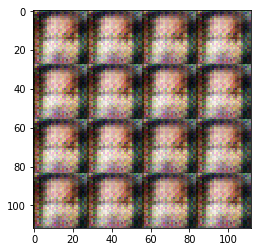

Epoch 1/5... Discriminator Loss: 0.7306... Generator Loss: 1.3951
Epoch 1/5... Discriminator Loss: 1.0552... Generator Loss: 0.9729
Epoch 1/5... Discriminator Loss: 0.8805... Generator Loss: 1.5353
Epoch 1/5... Discriminator Loss: 1.3377... Generator Loss: 1.0444
Epoch 1/5... Discriminator Loss: 2.0284... Generator Loss: 0.6890
Epoch 1/5... Discriminator Loss: 0.8607... Generator Loss: 2.0043
Epoch 1/5... Discriminator Loss: 2.1268... Generator Loss: 1.6554
Epoch 1/5... Discriminator Loss: 0.7896... Generator Loss: 1.4182
Epoch 1/5... Discriminator Loss: 1.1610... Generator Loss: 1.0461
Epoch 1/5... Discriminator Loss: 0.9489... Generator Loss: 1.1111


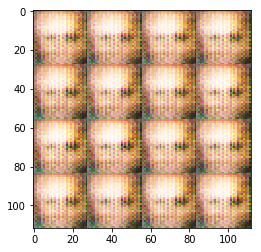

Epoch 1/5... Discriminator Loss: 0.6944... Generator Loss: 2.0862
Epoch 1/5... Discriminator Loss: 1.5801... Generator Loss: 1.2114
Epoch 1/5... Discriminator Loss: 0.8165... Generator Loss: 2.2510
Epoch 1/5... Discriminator Loss: 0.5534... Generator Loss: 5.2812
Epoch 1/5... Discriminator Loss: 1.4430... Generator Loss: 2.8069
Epoch 1/5... Discriminator Loss: 1.3330... Generator Loss: 2.1417
Epoch 1/5... Discriminator Loss: 0.7799... Generator Loss: 2.3641
Epoch 1/5... Discriminator Loss: 0.7022... Generator Loss: 2.4349
Epoch 1/5... Discriminator Loss: 0.7712... Generator Loss: 2.4724
Epoch 1/5... Discriminator Loss: 1.2682... Generator Loss: 1.0279


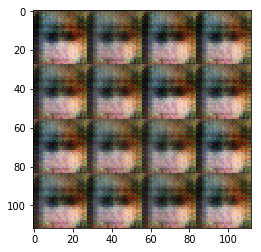

Epoch 1/5... Discriminator Loss: 0.9288... Generator Loss: 1.7077
Epoch 1/5... Discriminator Loss: 1.0459... Generator Loss: 2.0094
Epoch 1/5... Discriminator Loss: 0.6011... Generator Loss: 2.2221
Epoch 1/5... Discriminator Loss: 1.1654... Generator Loss: 1.0318
Epoch 1/5... Discriminator Loss: 0.8863... Generator Loss: 2.3944
Epoch 1/5... Discriminator Loss: 0.6665... Generator Loss: 1.6742
Epoch 1/5... Discriminator Loss: 0.7308... Generator Loss: 2.5004
Epoch 1/5... Discriminator Loss: 0.8011... Generator Loss: 2.2352
Epoch 1/5... Discriminator Loss: 1.1266... Generator Loss: 1.1266
Epoch 1/5... Discriminator Loss: 0.5428... Generator Loss: 2.5386


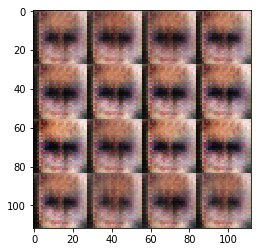

Epoch 1/5... Discriminator Loss: 0.6031... Generator Loss: 2.7304
Epoch 1/5... Discriminator Loss: 0.6337... Generator Loss: 1.9363
Epoch 1/5... Discriminator Loss: 0.7250... Generator Loss: 2.1778
Epoch 1/5... Discriminator Loss: 0.7123... Generator Loss: 1.7264
Epoch 1/5... Discriminator Loss: 1.5824... Generator Loss: 2.0321
Epoch 1/5... Discriminator Loss: 1.3585... Generator Loss: 0.5932
Epoch 1/5... Discriminator Loss: 1.3730... Generator Loss: 0.7803
Epoch 1/5... Discriminator Loss: 1.3560... Generator Loss: 1.1164
Epoch 1/5... Discriminator Loss: 0.9323... Generator Loss: 2.3865
Epoch 1/5... Discriminator Loss: 0.9358... Generator Loss: 0.8446


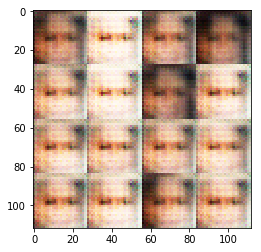

Epoch 1/5... Discriminator Loss: 1.6851... Generator Loss: 0.9543
Epoch 1/5... Discriminator Loss: 1.5275... Generator Loss: 1.4411
Epoch 1/5... Discriminator Loss: 1.8713... Generator Loss: 0.8245
Epoch 1/5... Discriminator Loss: 1.5781... Generator Loss: 0.6950
Epoch 1/5... Discriminator Loss: 1.9131... Generator Loss: 0.7168
Epoch 1/5... Discriminator Loss: 0.9658... Generator Loss: 1.1121
Epoch 1/5... Discriminator Loss: 1.4147... Generator Loss: 3.0240
Epoch 1/5... Discriminator Loss: 1.1024... Generator Loss: 1.1681
Epoch 1/5... Discriminator Loss: 0.8383... Generator Loss: 2.0702
Epoch 1/5... Discriminator Loss: 0.8836... Generator Loss: 1.6695


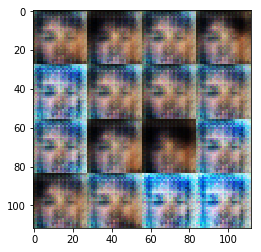

Epoch 1/5... Discriminator Loss: 1.2518... Generator Loss: 1.2079
Epoch 1/5... Discriminator Loss: 0.8180... Generator Loss: 1.7461
Epoch 1/5... Discriminator Loss: 0.8200... Generator Loss: 1.6875
Epoch 1/5... Discriminator Loss: 0.8094... Generator Loss: 2.0364
Epoch 1/5... Discriminator Loss: 1.2486... Generator Loss: 1.2581
Epoch 1/5... Discriminator Loss: 0.8595... Generator Loss: 1.5601
Epoch 1/5... Discriminator Loss: 2.1791... Generator Loss: 0.4528
Epoch 1/5... Discriminator Loss: 0.8755... Generator Loss: 1.9815
Epoch 1/5... Discriminator Loss: 1.3224... Generator Loss: 1.4275
Epoch 1/5... Discriminator Loss: 1.2875... Generator Loss: 1.7141


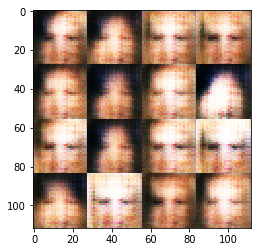

Epoch 1/5... Discriminator Loss: 1.1655... Generator Loss: 1.2433
Epoch 1/5... Discriminator Loss: 2.4992... Generator Loss: 2.3061
Epoch 1/5... Discriminator Loss: 0.7757... Generator Loss: 1.7829
Epoch 1/5... Discriminator Loss: 0.9904... Generator Loss: 1.0462
Epoch 1/5... Discriminator Loss: 1.0564... Generator Loss: 1.3063
Epoch 1/5... Discriminator Loss: 1.0869... Generator Loss: 1.7983
Epoch 1/5... Discriminator Loss: 1.1897... Generator Loss: 1.1815
Epoch 1/5... Discriminator Loss: 1.0892... Generator Loss: 1.3729
Epoch 1/5... Discriminator Loss: 1.0890... Generator Loss: 1.0423
Epoch 1/5... Discriminator Loss: 1.0441... Generator Loss: 2.5573


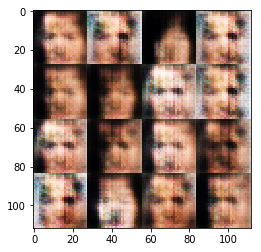

Epoch 1/5... Discriminator Loss: 0.9125... Generator Loss: 1.8650
Epoch 1/5... Discriminator Loss: 0.9133... Generator Loss: 1.4525
Epoch 1/5... Discriminator Loss: 1.2467... Generator Loss: 1.2986
Epoch 1/5... Discriminator Loss: 1.7501... Generator Loss: 0.6194
Epoch 1/5... Discriminator Loss: 1.0449... Generator Loss: 1.4744
Epoch 1/5... Discriminator Loss: 1.1927... Generator Loss: 1.1161
Epoch 1/5... Discriminator Loss: 0.9882... Generator Loss: 2.1993
Epoch 1/5... Discriminator Loss: 1.2459... Generator Loss: 1.0217
Epoch 1/5... Discriminator Loss: 1.5505... Generator Loss: 1.4796
Epoch 1/5... Discriminator Loss: 2.0319... Generator Loss: 0.3372


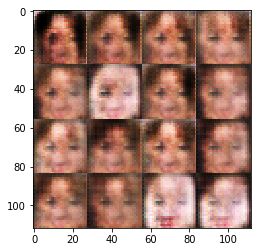

Epoch 1/5... Discriminator Loss: 1.6514... Generator Loss: 1.1399
Epoch 1/5... Discriminator Loss: 1.3755... Generator Loss: 0.9352
Epoch 1/5... Discriminator Loss: 1.6681... Generator Loss: 0.6849
Epoch 1/5... Discriminator Loss: 1.1319... Generator Loss: 2.2278
Epoch 1/5... Discriminator Loss: 1.7766... Generator Loss: 0.5932
Epoch 1/5... Discriminator Loss: 1.5808... Generator Loss: 0.6965
Epoch 1/5... Discriminator Loss: 1.2072... Generator Loss: 0.8732
Epoch 1/5... Discriminator Loss: 1.1180... Generator Loss: 1.0114
Epoch 1/5... Discriminator Loss: 1.3770... Generator Loss: 0.7518
Epoch 1/5... Discriminator Loss: 1.4590... Generator Loss: 1.1533


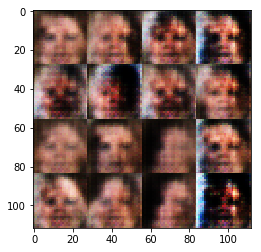

Epoch 1/5... Discriminator Loss: 1.5120... Generator Loss: 1.0879
Epoch 1/5... Discriminator Loss: 1.4221... Generator Loss: 0.7214
Epoch 1/5... Discriminator Loss: 2.0272... Generator Loss: 0.9486
Epoch 1/5... Discriminator Loss: 1.9541... Generator Loss: 1.1098
Epoch 1/5... Discriminator Loss: 1.4595... Generator Loss: 1.9939
Epoch 1/5... Discriminator Loss: 1.3178... Generator Loss: 1.5922
Epoch 1/5... Discriminator Loss: 0.8933... Generator Loss: 1.4947
Epoch 1/5... Discriminator Loss: 0.6133... Generator Loss: 1.8370
Epoch 1/5... Discriminator Loss: 1.2757... Generator Loss: 1.4767
Epoch 1/5... Discriminator Loss: 1.1578... Generator Loss: 1.6176


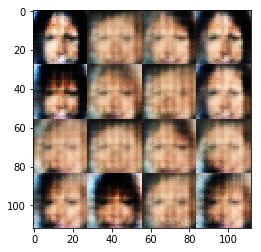

Epoch 1/5... Discriminator Loss: 1.1386... Generator Loss: 1.1307
Epoch 1/5... Discriminator Loss: 1.5934... Generator Loss: 0.4178
Epoch 1/5... Discriminator Loss: 1.4485... Generator Loss: 0.6433
Epoch 1/5... Discriminator Loss: 1.5329... Generator Loss: 0.7117
Epoch 1/5... Discriminator Loss: 1.7254... Generator Loss: 0.7146
Epoch 1/5... Discriminator Loss: 1.1155... Generator Loss: 1.2006
Epoch 1/5... Discriminator Loss: 0.9204... Generator Loss: 1.6845
Epoch 1/5... Discriminator Loss: 1.5458... Generator Loss: 1.3751
Epoch 1/5... Discriminator Loss: 1.0843... Generator Loss: 0.9982
Epoch 1/5... Discriminator Loss: 1.3085... Generator Loss: 0.9788


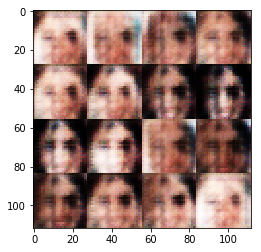

Epoch 1/5... Discriminator Loss: 1.1314... Generator Loss: 1.1942
Epoch 1/5... Discriminator Loss: 1.2586... Generator Loss: 1.7358
Epoch 1/5... Discriminator Loss: 1.5701... Generator Loss: 0.6417
Epoch 1/5... Discriminator Loss: 1.0359... Generator Loss: 1.1272
Epoch 1/5... Discriminator Loss: 1.2028... Generator Loss: 1.2338
Epoch 1/5... Discriminator Loss: 1.1012... Generator Loss: 1.2445
Epoch 1/5... Discriminator Loss: 1.2137... Generator Loss: 1.0130
Epoch 1/5... Discriminator Loss: 1.4084... Generator Loss: 1.4936
Epoch 1/5... Discriminator Loss: 0.9892... Generator Loss: 1.2637
Epoch 1/5... Discriminator Loss: 1.3859... Generator Loss: 1.2570


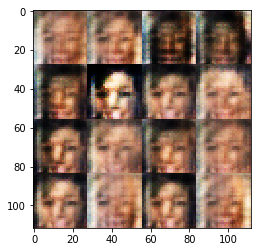

Epoch 1/5... Discriminator Loss: 1.1688... Generator Loss: 1.0913
Epoch 1/5... Discriminator Loss: 1.5716... Generator Loss: 1.1701
Epoch 1/5... Discriminator Loss: 1.4345... Generator Loss: 1.1352
Epoch 1/5... Discriminator Loss: 1.4452... Generator Loss: 1.2531
Epoch 1/5... Discriminator Loss: 1.1429... Generator Loss: 1.3178
Epoch 1/5... Discriminator Loss: 2.3523... Generator Loss: 0.5178
Epoch 1/5... Discriminator Loss: 1.0984... Generator Loss: 1.4740
Epoch 1/5... Discriminator Loss: 1.1285... Generator Loss: 1.2508
Epoch 2/5... Discriminator Loss: 1.4317... Generator Loss: 0.9654
Epoch 2/5... Discriminator Loss: 1.4631... Generator Loss: 0.6438


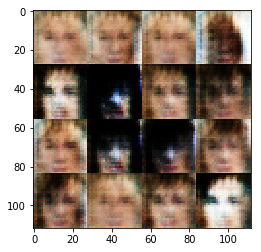

Epoch 2/5... Discriminator Loss: 1.0305... Generator Loss: 1.6319
Epoch 2/5... Discriminator Loss: 1.1032... Generator Loss: 1.1938
Epoch 2/5... Discriminator Loss: 1.1570... Generator Loss: 1.3062
Epoch 2/5... Discriminator Loss: 1.0519... Generator Loss: 2.2055
Epoch 2/5... Discriminator Loss: 1.1704... Generator Loss: 0.8212
Epoch 2/5... Discriminator Loss: 1.5210... Generator Loss: 1.0287
Epoch 2/5... Discriminator Loss: 1.5029... Generator Loss: 0.8321
Epoch 2/5... Discriminator Loss: 1.2538... Generator Loss: 1.0939
Epoch 2/5... Discriminator Loss: 1.4201... Generator Loss: 0.7305
Epoch 2/5... Discriminator Loss: 1.6345... Generator Loss: 0.6312


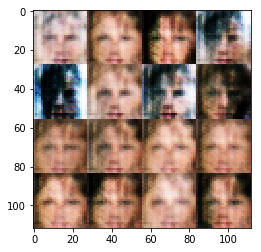

Epoch 2/5... Discriminator Loss: 0.8289... Generator Loss: 2.3402
Epoch 2/5... Discriminator Loss: 1.3527... Generator Loss: 1.5961
Epoch 2/5... Discriminator Loss: 1.2149... Generator Loss: 1.1806
Epoch 2/5... Discriminator Loss: 1.1626... Generator Loss: 0.9293
Epoch 2/5... Discriminator Loss: 1.5113... Generator Loss: 0.8830
Epoch 2/5... Discriminator Loss: 1.5580... Generator Loss: 0.9950
Epoch 2/5... Discriminator Loss: 1.0798... Generator Loss: 0.8767
Epoch 2/5... Discriminator Loss: 1.4627... Generator Loss: 0.9077
Epoch 2/5... Discriminator Loss: 1.7626... Generator Loss: 1.2838
Epoch 2/5... Discriminator Loss: 1.6505... Generator Loss: 0.4555


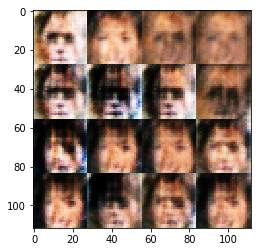

Epoch 2/5... Discriminator Loss: 2.0286... Generator Loss: 1.1287
Epoch 2/5... Discriminator Loss: 1.6130... Generator Loss: 0.8841
Epoch 2/5... Discriminator Loss: 2.2440... Generator Loss: 0.5967
Epoch 2/5... Discriminator Loss: 1.5366... Generator Loss: 0.7273
Epoch 2/5... Discriminator Loss: 1.1378... Generator Loss: 1.5651
Epoch 2/5... Discriminator Loss: 1.9926... Generator Loss: 1.0238
Epoch 2/5... Discriminator Loss: 1.8179... Generator Loss: 0.7564
Epoch 2/5... Discriminator Loss: 1.3385... Generator Loss: 0.6893
Epoch 2/5... Discriminator Loss: 2.0702... Generator Loss: 0.3638
Epoch 2/5... Discriminator Loss: 1.8098... Generator Loss: 0.5972


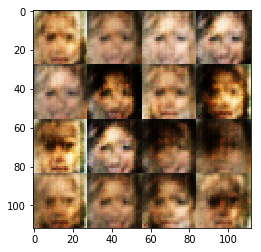

Epoch 2/5... Discriminator Loss: 1.4896... Generator Loss: 0.8588
Epoch 2/5... Discriminator Loss: 1.0886... Generator Loss: 1.0381
Epoch 2/5... Discriminator Loss: 1.3362... Generator Loss: 0.9879
Epoch 2/5... Discriminator Loss: 1.7177... Generator Loss: 1.1148
Epoch 2/5... Discriminator Loss: 1.4390... Generator Loss: 0.8587
Epoch 2/5... Discriminator Loss: 1.7188... Generator Loss: 0.3988
Epoch 2/5... Discriminator Loss: 1.9323... Generator Loss: 0.5063
Epoch 2/5... Discriminator Loss: 1.2922... Generator Loss: 1.6530
Epoch 2/5... Discriminator Loss: 1.1613... Generator Loss: 1.1834
Epoch 2/5... Discriminator Loss: 1.8403... Generator Loss: 0.4227


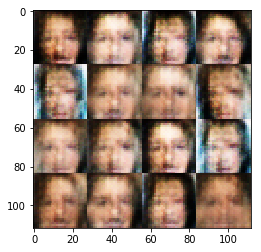

Epoch 2/5... Discriminator Loss: 1.5551... Generator Loss: 1.2538
Epoch 2/5... Discriminator Loss: 1.4854... Generator Loss: 0.6611
Epoch 2/5... Discriminator Loss: 1.6558... Generator Loss: 1.3412
Epoch 2/5... Discriminator Loss: 1.4641... Generator Loss: 0.7636
Epoch 2/5... Discriminator Loss: 1.1835... Generator Loss: 1.2532
Epoch 2/5... Discriminator Loss: 1.3610... Generator Loss: 0.7341
Epoch 2/5... Discriminator Loss: 1.8495... Generator Loss: 0.6057
Epoch 2/5... Discriminator Loss: 1.6248... Generator Loss: 0.6239
Epoch 2/5... Discriminator Loss: 1.6064... Generator Loss: 0.8529
Epoch 2/5... Discriminator Loss: 1.5320... Generator Loss: 0.7490


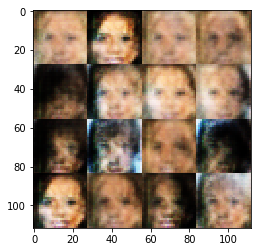

Epoch 2/5... Discriminator Loss: 1.4898... Generator Loss: 1.0631
Epoch 2/5... Discriminator Loss: 1.3011... Generator Loss: 1.6246
Epoch 2/5... Discriminator Loss: 1.2485... Generator Loss: 0.8990
Epoch 2/5... Discriminator Loss: 1.2107... Generator Loss: 1.2709
Epoch 2/5... Discriminator Loss: 1.2728... Generator Loss: 0.9407
Epoch 2/5... Discriminator Loss: 1.1697... Generator Loss: 1.6263
Epoch 2/5... Discriminator Loss: 1.3975... Generator Loss: 0.9425
Epoch 2/5... Discriminator Loss: 1.5295... Generator Loss: 0.9101
Epoch 2/5... Discriminator Loss: 1.4460... Generator Loss: 1.7955
Epoch 2/5... Discriminator Loss: 1.0795... Generator Loss: 1.5788


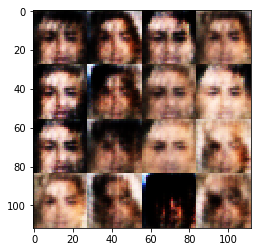

Epoch 2/5... Discriminator Loss: 1.0349... Generator Loss: 1.7079
Epoch 2/5... Discriminator Loss: 1.1535... Generator Loss: 1.0516
Epoch 2/5... Discriminator Loss: 1.4337... Generator Loss: 0.7559
Epoch 2/5... Discriminator Loss: 0.9491... Generator Loss: 2.1211
Epoch 2/5... Discriminator Loss: 1.4345... Generator Loss: 1.2214
Epoch 2/5... Discriminator Loss: 1.1520... Generator Loss: 1.3066
Epoch 2/5... Discriminator Loss: 1.4114... Generator Loss: 0.5048
Epoch 2/5... Discriminator Loss: 1.1028... Generator Loss: 1.4487
Epoch 2/5... Discriminator Loss: 1.6409... Generator Loss: 0.5629
Epoch 2/5... Discriminator Loss: 1.4364... Generator Loss: 1.0361


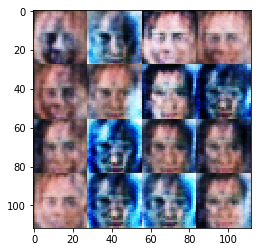

Epoch 2/5... Discriminator Loss: 1.8337... Generator Loss: 0.7500
Epoch 2/5... Discriminator Loss: 1.7290... Generator Loss: 0.8737
Epoch 2/5... Discriminator Loss: 1.3175... Generator Loss: 0.7337
Epoch 2/5... Discriminator Loss: 1.3829... Generator Loss: 1.2675
Epoch 2/5... Discriminator Loss: 1.3632... Generator Loss: 1.5450
Epoch 2/5... Discriminator Loss: 1.5304... Generator Loss: 0.8099
Epoch 2/5... Discriminator Loss: 1.4996... Generator Loss: 1.1424
Epoch 2/5... Discriminator Loss: 1.3872... Generator Loss: 0.8444
Epoch 2/5... Discriminator Loss: 1.5438... Generator Loss: 0.8487
Epoch 2/5... Discriminator Loss: 1.1559... Generator Loss: 0.9893


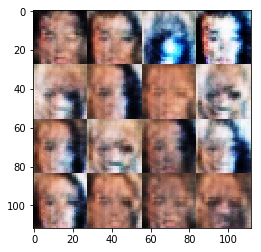

Epoch 2/5... Discriminator Loss: 1.5003... Generator Loss: 1.0967
Epoch 2/5... Discriminator Loss: 1.8226... Generator Loss: 0.5824
Epoch 2/5... Discriminator Loss: 2.4018... Generator Loss: 0.8704
Epoch 2/5... Discriminator Loss: 1.4894... Generator Loss: 1.1780
Epoch 2/5... Discriminator Loss: 1.4499... Generator Loss: 1.7175
Epoch 2/5... Discriminator Loss: 1.2402... Generator Loss: 1.2083
Epoch 2/5... Discriminator Loss: 1.5035... Generator Loss: 1.6395
Epoch 2/5... Discriminator Loss: 1.3590... Generator Loss: 1.0622
Epoch 2/5... Discriminator Loss: 1.3296... Generator Loss: 1.6745
Epoch 2/5... Discriminator Loss: 1.2610... Generator Loss: 1.3111


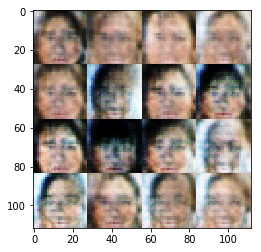

Epoch 2/5... Discriminator Loss: 1.7317... Generator Loss: 1.5421
Epoch 2/5... Discriminator Loss: 1.6491... Generator Loss: 0.9958
Epoch 2/5... Discriminator Loss: 1.5976... Generator Loss: 0.5380
Epoch 2/5... Discriminator Loss: 1.4009... Generator Loss: 1.2384
Epoch 2/5... Discriminator Loss: 1.6889... Generator Loss: 0.6481
Epoch 2/5... Discriminator Loss: 1.3207... Generator Loss: 0.6655
Epoch 2/5... Discriminator Loss: 1.0518... Generator Loss: 1.3837
Epoch 2/5... Discriminator Loss: 1.5527... Generator Loss: 1.0541
Epoch 2/5... Discriminator Loss: 1.5198... Generator Loss: 0.6064
Epoch 2/5... Discriminator Loss: 1.5481... Generator Loss: 0.6191


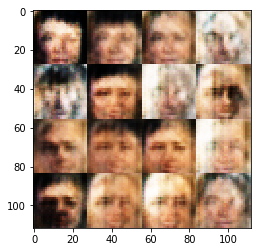

Epoch 2/5... Discriminator Loss: 1.1770... Generator Loss: 1.0273
Epoch 2/5... Discriminator Loss: 1.5446... Generator Loss: 1.0610
Epoch 2/5... Discriminator Loss: 1.1079... Generator Loss: 1.1772
Epoch 2/5... Discriminator Loss: 0.9661... Generator Loss: 1.6386
Epoch 2/5... Discriminator Loss: 1.5043... Generator Loss: 1.2765
Epoch 2/5... Discriminator Loss: 1.5492... Generator Loss: 1.3961
Epoch 2/5... Discriminator Loss: 1.6969... Generator Loss: 0.4722
Epoch 2/5... Discriminator Loss: 1.6867... Generator Loss: 0.8488
Epoch 2/5... Discriminator Loss: 1.4005... Generator Loss: 1.5074
Epoch 2/5... Discriminator Loss: 1.7892... Generator Loss: 1.3290


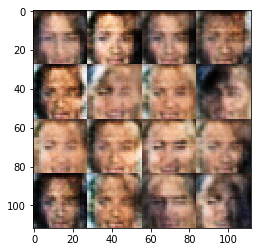

Epoch 2/5... Discriminator Loss: 1.6857... Generator Loss: 1.1793
Epoch 2/5... Discriminator Loss: 1.6127... Generator Loss: 1.5680
Epoch 2/5... Discriminator Loss: 1.5873... Generator Loss: 0.9644
Epoch 2/5... Discriminator Loss: 1.4182... Generator Loss: 0.7923
Epoch 2/5... Discriminator Loss: 1.1916... Generator Loss: 1.2080
Epoch 2/5... Discriminator Loss: 1.0506... Generator Loss: 1.4278
Epoch 2/5... Discriminator Loss: 1.2899... Generator Loss: 0.9842
Epoch 2/5... Discriminator Loss: 1.0591... Generator Loss: 1.1959
Epoch 2/5... Discriminator Loss: 1.4604... Generator Loss: 0.9723
Epoch 2/5... Discriminator Loss: 1.4051... Generator Loss: 0.9980


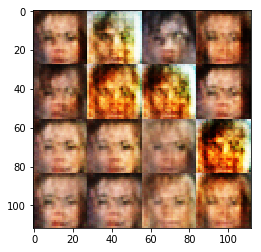

Epoch 2/5... Discriminator Loss: 1.1482... Generator Loss: 0.8047
Epoch 2/5... Discriminator Loss: 1.3533... Generator Loss: 0.8940
Epoch 2/5... Discriminator Loss: 1.2845... Generator Loss: 0.8197
Epoch 2/5... Discriminator Loss: 1.6142... Generator Loss: 0.5504
Epoch 2/5... Discriminator Loss: 1.7614... Generator Loss: 0.6433
Epoch 2/5... Discriminator Loss: 1.7818... Generator Loss: 0.4880
Epoch 2/5... Discriminator Loss: 1.5346... Generator Loss: 0.8640
Epoch 2/5... Discriminator Loss: 1.4742... Generator Loss: 1.3983
Epoch 2/5... Discriminator Loss: 1.4828... Generator Loss: 0.9157
Epoch 2/5... Discriminator Loss: 1.4531... Generator Loss: 0.7881


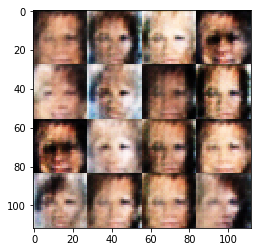

Epoch 2/5... Discriminator Loss: 1.0912... Generator Loss: 1.5794
Epoch 2/5... Discriminator Loss: 1.6619... Generator Loss: 0.5014
Epoch 2/5... Discriminator Loss: 1.4695... Generator Loss: 0.8921
Epoch 2/5... Discriminator Loss: 1.5402... Generator Loss: 1.0219
Epoch 2/5... Discriminator Loss: 1.5778... Generator Loss: 0.6738
Epoch 2/5... Discriminator Loss: 2.0484... Generator Loss: 0.6511
Epoch 2/5... Discriminator Loss: 1.3540... Generator Loss: 0.6107
Epoch 2/5... Discriminator Loss: 1.1965... Generator Loss: 1.4149
Epoch 2/5... Discriminator Loss: 0.9471... Generator Loss: 1.8782
Epoch 2/5... Discriminator Loss: 1.6541... Generator Loss: 0.7167


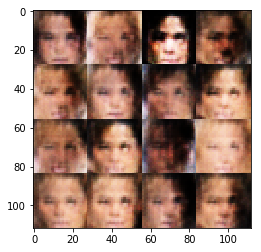

Epoch 2/5... Discriminator Loss: 1.6882... Generator Loss: 0.5780
Epoch 2/5... Discriminator Loss: 1.3338... Generator Loss: 0.8713
Epoch 2/5... Discriminator Loss: 1.2837... Generator Loss: 1.5867
Epoch 2/5... Discriminator Loss: 1.5359... Generator Loss: 0.7137
Epoch 2/5... Discriminator Loss: 1.6610... Generator Loss: 0.6499
Epoch 2/5... Discriminator Loss: 1.4894... Generator Loss: 1.0578
Epoch 2/5... Discriminator Loss: 1.6036... Generator Loss: 1.0047
Epoch 2/5... Discriminator Loss: 1.2868... Generator Loss: 0.9884
Epoch 2/5... Discriminator Loss: 1.5784... Generator Loss: 0.5603
Epoch 2/5... Discriminator Loss: 1.1545... Generator Loss: 1.3150


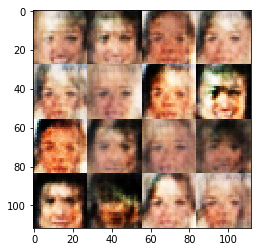

Epoch 2/5... Discriminator Loss: 0.9494... Generator Loss: 1.4711
Epoch 2/5... Discriminator Loss: 1.5610... Generator Loss: 1.6022
Epoch 2/5... Discriminator Loss: 1.7767... Generator Loss: 0.8437
Epoch 2/5... Discriminator Loss: 1.4872... Generator Loss: 0.9463
Epoch 2/5... Discriminator Loss: 1.4236... Generator Loss: 1.2392
Epoch 2/5... Discriminator Loss: 1.3177... Generator Loss: 1.1085
Epoch 2/5... Discriminator Loss: 1.7891... Generator Loss: 0.7637
Epoch 2/5... Discriminator Loss: 1.6918... Generator Loss: 0.8965
Epoch 2/5... Discriminator Loss: 1.2721... Generator Loss: 1.0286
Epoch 2/5... Discriminator Loss: 1.4390... Generator Loss: 1.0556


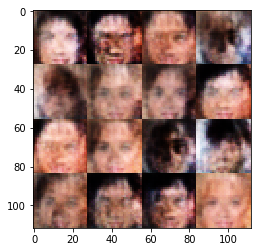

Epoch 2/5... Discriminator Loss: 1.2143... Generator Loss: 1.3129
Epoch 2/5... Discriminator Loss: 1.6175... Generator Loss: 1.1387
Epoch 2/5... Discriminator Loss: 1.4144... Generator Loss: 1.1139
Epoch 2/5... Discriminator Loss: 1.5744... Generator Loss: 1.0102
Epoch 2/5... Discriminator Loss: 1.4633... Generator Loss: 0.7410
Epoch 2/5... Discriminator Loss: 1.5580... Generator Loss: 0.6233
Epoch 2/5... Discriminator Loss: 1.4606... Generator Loss: 1.0570
Epoch 3/5... Discriminator Loss: 1.7135... Generator Loss: 0.5831
Epoch 3/5... Discriminator Loss: 1.4421... Generator Loss: 0.9008
Epoch 3/5... Discriminator Loss: 1.3896... Generator Loss: 0.9388


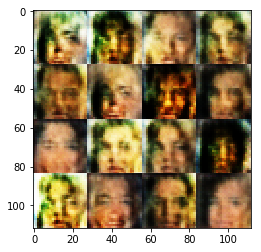

Epoch 3/5... Discriminator Loss: 1.3231... Generator Loss: 1.3662
Epoch 3/5... Discriminator Loss: 1.6947... Generator Loss: 1.1622
Epoch 3/5... Discriminator Loss: 1.5729... Generator Loss: 1.0006
Epoch 3/5... Discriminator Loss: 1.1612... Generator Loss: 1.1067
Epoch 3/5... Discriminator Loss: 1.5112... Generator Loss: 0.8626
Epoch 3/5... Discriminator Loss: 1.8447... Generator Loss: 0.5970
Epoch 3/5... Discriminator Loss: 1.4043... Generator Loss: 0.7515
Epoch 3/5... Discriminator Loss: 1.7572... Generator Loss: 0.5661
Epoch 3/5... Discriminator Loss: 1.2414... Generator Loss: 0.9859
Epoch 3/5... Discriminator Loss: 1.1543... Generator Loss: 0.8622


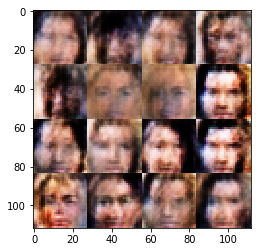

Epoch 3/5... Discriminator Loss: 1.5971... Generator Loss: 0.6658
Epoch 3/5... Discriminator Loss: 1.7752... Generator Loss: 0.5605
Epoch 3/5... Discriminator Loss: 1.9386... Generator Loss: 0.7083
Epoch 3/5... Discriminator Loss: 1.5643... Generator Loss: 0.8865
Epoch 3/5... Discriminator Loss: 1.7901... Generator Loss: 0.8614
Epoch 3/5... Discriminator Loss: 1.5041... Generator Loss: 0.9335
Epoch 3/5... Discriminator Loss: 1.2601... Generator Loss: 0.8435
Epoch 3/5... Discriminator Loss: 1.3547... Generator Loss: 0.8499
Epoch 3/5... Discriminator Loss: 1.7391... Generator Loss: 0.6455
Epoch 3/5... Discriminator Loss: 1.4821... Generator Loss: 0.6540


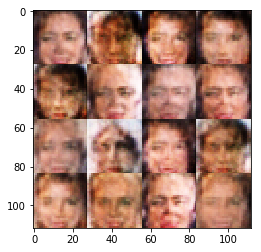

Epoch 3/5... Discriminator Loss: 1.6447... Generator Loss: 0.5234
Epoch 3/5... Discriminator Loss: 1.6073... Generator Loss: 0.8353
Epoch 3/5... Discriminator Loss: 1.3673... Generator Loss: 1.0598
Epoch 3/5... Discriminator Loss: 1.3440... Generator Loss: 1.0183
Epoch 3/5... Discriminator Loss: 1.3685... Generator Loss: 1.4023
Epoch 3/5... Discriminator Loss: 1.5454... Generator Loss: 1.2237
Epoch 3/5... Discriminator Loss: 1.5645... Generator Loss: 0.8743
Epoch 3/5... Discriminator Loss: 1.3656... Generator Loss: 0.8994
Epoch 3/5... Discriminator Loss: 1.4130... Generator Loss: 1.3312
Epoch 3/5... Discriminator Loss: 1.7524... Generator Loss: 0.6814


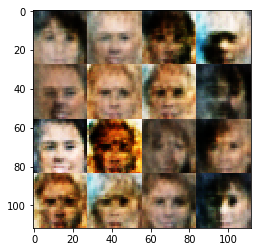

Epoch 3/5... Discriminator Loss: 1.3204... Generator Loss: 0.7317
Epoch 3/5... Discriminator Loss: 1.2709... Generator Loss: 0.9995
Epoch 3/5... Discriminator Loss: 1.4148... Generator Loss: 0.8745
Epoch 3/5... Discriminator Loss: 1.3803... Generator Loss: 0.6783
Epoch 3/5... Discriminator Loss: 1.5318... Generator Loss: 0.6067
Epoch 3/5... Discriminator Loss: 2.1458... Generator Loss: 0.7369
Epoch 3/5... Discriminator Loss: 1.4737... Generator Loss: 0.7947
Epoch 3/5... Discriminator Loss: 1.4455... Generator Loss: 1.1390
Epoch 3/5... Discriminator Loss: 1.3256... Generator Loss: 0.8850
Epoch 3/5... Discriminator Loss: 1.3398... Generator Loss: 1.0257


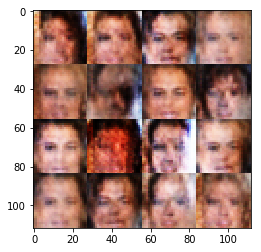

Epoch 3/5... Discriminator Loss: 1.4501... Generator Loss: 1.1173
Epoch 3/5... Discriminator Loss: 1.1197... Generator Loss: 0.9952
Epoch 3/5... Discriminator Loss: 1.1589... Generator Loss: 0.7525
Epoch 3/5... Discriminator Loss: 1.9865... Generator Loss: 0.4141
Epoch 3/5... Discriminator Loss: 1.1209... Generator Loss: 1.5418
Epoch 3/5... Discriminator Loss: 1.3847... Generator Loss: 0.7250
Epoch 3/5... Discriminator Loss: 1.7818... Generator Loss: 1.0868
Epoch 3/5... Discriminator Loss: 1.2284... Generator Loss: 1.1388
Epoch 3/5... Discriminator Loss: 1.4349... Generator Loss: 0.6985
Epoch 3/5... Discriminator Loss: 1.4503... Generator Loss: 1.3780


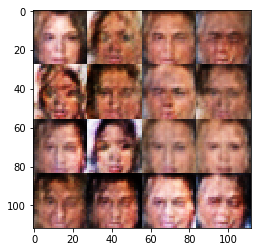

Epoch 3/5... Discriminator Loss: 1.9704... Generator Loss: 0.5430
Epoch 3/5... Discriminator Loss: 1.0913... Generator Loss: 1.0244
Epoch 3/5... Discriminator Loss: 1.4230... Generator Loss: 1.2132
Epoch 3/5... Discriminator Loss: 1.5489... Generator Loss: 0.6788
Epoch 3/5... Discriminator Loss: 1.5632... Generator Loss: 0.8752
Epoch 3/5... Discriminator Loss: 0.8209... Generator Loss: 1.3711
Epoch 3/5... Discriminator Loss: 1.7621... Generator Loss: 0.4557
Epoch 3/5... Discriminator Loss: 1.3509... Generator Loss: 1.5938
Epoch 3/5... Discriminator Loss: 1.6000... Generator Loss: 1.2762
Epoch 3/5... Discriminator Loss: 1.4379... Generator Loss: 1.0276


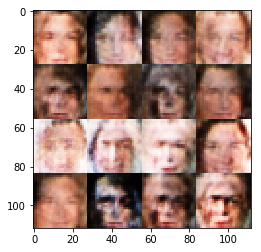

Epoch 3/5... Discriminator Loss: 1.3511... Generator Loss: 0.6430
Epoch 3/5... Discriminator Loss: 1.3614... Generator Loss: 1.0767
Epoch 3/5... Discriminator Loss: 1.5591... Generator Loss: 1.0702
Epoch 3/5... Discriminator Loss: 1.8066... Generator Loss: 1.0527
Epoch 3/5... Discriminator Loss: 1.3603... Generator Loss: 0.5608
Epoch 3/5... Discriminator Loss: 1.4156... Generator Loss: 0.9708
Epoch 3/5... Discriminator Loss: 1.1595... Generator Loss: 1.0513
Epoch 3/5... Discriminator Loss: 1.3295... Generator Loss: 1.3534
Epoch 3/5... Discriminator Loss: 1.3500... Generator Loss: 0.7751
Epoch 3/5... Discriminator Loss: 1.1809... Generator Loss: 0.8962


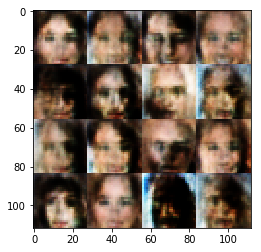

Epoch 3/5... Discriminator Loss: 1.5389... Generator Loss: 0.6394
Epoch 3/5... Discriminator Loss: 1.5832... Generator Loss: 0.7253
Epoch 3/5... Discriminator Loss: 1.6270... Generator Loss: 0.6477
Epoch 3/5... Discriminator Loss: 1.6796... Generator Loss: 0.7766
Epoch 3/5... Discriminator Loss: 1.6119... Generator Loss: 0.8812
Epoch 3/5... Discriminator Loss: 1.6963... Generator Loss: 0.8707
Epoch 3/5... Discriminator Loss: 1.4135... Generator Loss: 0.9015
Epoch 3/5... Discriminator Loss: 1.2546... Generator Loss: 1.3031
Epoch 3/5... Discriminator Loss: 1.6671... Generator Loss: 0.7469
Epoch 3/5... Discriminator Loss: 1.7827... Generator Loss: 0.4732


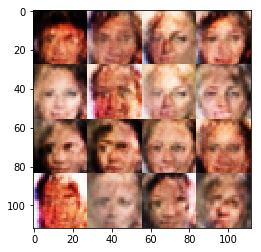

Epoch 3/5... Discriminator Loss: 1.7087... Generator Loss: 0.8660
Epoch 3/5... Discriminator Loss: 1.6143... Generator Loss: 0.8052
Epoch 3/5... Discriminator Loss: 1.5293... Generator Loss: 0.6827
Epoch 3/5... Discriminator Loss: 1.3123... Generator Loss: 1.0625
Epoch 3/5... Discriminator Loss: 1.6383... Generator Loss: 1.4772
Epoch 3/5... Discriminator Loss: 1.5491... Generator Loss: 0.5590
Epoch 3/5... Discriminator Loss: 1.3168... Generator Loss: 0.9109
Epoch 3/5... Discriminator Loss: 1.2930... Generator Loss: 1.2084
Epoch 3/5... Discriminator Loss: 1.5041... Generator Loss: 0.6624
Epoch 3/5... Discriminator Loss: 1.2246... Generator Loss: 1.0577


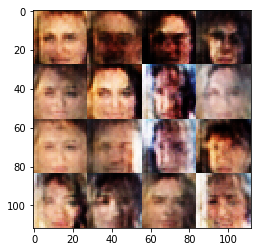

Epoch 3/5... Discriminator Loss: 1.3056... Generator Loss: 0.9729
Epoch 3/5... Discriminator Loss: 1.7480... Generator Loss: 0.5651
Epoch 3/5... Discriminator Loss: 1.6135... Generator Loss: 0.4684
Epoch 3/5... Discriminator Loss: 1.0263... Generator Loss: 1.2371
Epoch 3/5... Discriminator Loss: 1.3524... Generator Loss: 1.0160
Epoch 3/5... Discriminator Loss: 1.4172... Generator Loss: 0.9835
Epoch 3/5... Discriminator Loss: 1.1236... Generator Loss: 0.7264
Epoch 3/5... Discriminator Loss: 1.4399... Generator Loss: 0.7170
Epoch 3/5... Discriminator Loss: 1.5448... Generator Loss: 0.5682
Epoch 3/5... Discriminator Loss: 1.7370... Generator Loss: 0.6418


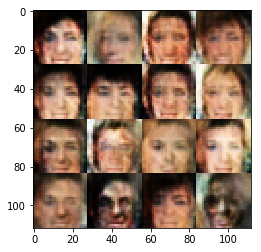

Epoch 3/5... Discriminator Loss: 1.6409... Generator Loss: 1.1115
Epoch 3/5... Discriminator Loss: 1.4492... Generator Loss: 1.1982
Epoch 3/5... Discriminator Loss: 1.8209... Generator Loss: 0.7191
Epoch 3/5... Discriminator Loss: 1.6246... Generator Loss: 0.8274
Epoch 3/5... Discriminator Loss: 1.4357... Generator Loss: 0.9080
Epoch 3/5... Discriminator Loss: 1.2681... Generator Loss: 1.1423
Epoch 3/5... Discriminator Loss: 1.7928... Generator Loss: 0.5262
Epoch 3/5... Discriminator Loss: 1.5634... Generator Loss: 0.7880
Epoch 3/5... Discriminator Loss: 1.2753... Generator Loss: 0.8906
Epoch 3/5... Discriminator Loss: 1.5602... Generator Loss: 0.6234


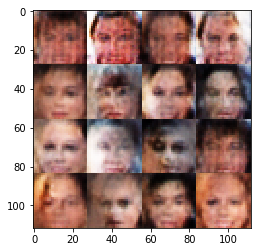

Epoch 3/5... Discriminator Loss: 1.8488... Generator Loss: 0.4019
Epoch 3/5... Discriminator Loss: 1.3774... Generator Loss: 1.1229
Epoch 3/5... Discriminator Loss: 1.3309... Generator Loss: 0.8912
Epoch 3/5... Discriminator Loss: 1.5102... Generator Loss: 0.8618
Epoch 3/5... Discriminator Loss: 1.4210... Generator Loss: 1.0896
Epoch 3/5... Discriminator Loss: 1.7950... Generator Loss: 0.5801
Epoch 3/5... Discriminator Loss: 1.1046... Generator Loss: 1.1296
Epoch 3/5... Discriminator Loss: 1.3910... Generator Loss: 1.0637
Epoch 3/5... Discriminator Loss: 1.6344... Generator Loss: 1.0685
Epoch 3/5... Discriminator Loss: 1.5437... Generator Loss: 1.0548


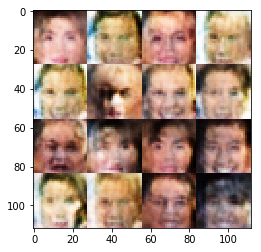

Epoch 3/5... Discriminator Loss: 1.3559... Generator Loss: 1.2214
Epoch 3/5... Discriminator Loss: 1.4353... Generator Loss: 1.0859
Epoch 3/5... Discriminator Loss: 1.5798... Generator Loss: 0.7419
Epoch 3/5... Discriminator Loss: 1.4068... Generator Loss: 1.0919
Epoch 3/5... Discriminator Loss: 1.5742... Generator Loss: 0.7832
Epoch 3/5... Discriminator Loss: 1.5670... Generator Loss: 0.7570
Epoch 3/5... Discriminator Loss: 1.6178... Generator Loss: 0.6665
Epoch 3/5... Discriminator Loss: 1.4703... Generator Loss: 0.8426
Epoch 3/5... Discriminator Loss: 1.6101... Generator Loss: 0.9145
Epoch 3/5... Discriminator Loss: 1.2539... Generator Loss: 1.1339


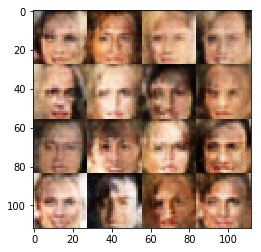

Epoch 3/5... Discriminator Loss: 1.3564... Generator Loss: 0.8989
Epoch 3/5... Discriminator Loss: 1.2063... Generator Loss: 0.9514
Epoch 3/5... Discriminator Loss: 1.3954... Generator Loss: 0.6781
Epoch 3/5... Discriminator Loss: 1.4751... Generator Loss: 0.7604
Epoch 3/5... Discriminator Loss: 1.3138... Generator Loss: 0.7795
Epoch 3/5... Discriminator Loss: 1.5737... Generator Loss: 0.8498
Epoch 3/5... Discriminator Loss: 1.5997... Generator Loss: 0.8100
Epoch 3/5... Discriminator Loss: 1.5423... Generator Loss: 0.9376
Epoch 3/5... Discriminator Loss: 1.6085... Generator Loss: 0.5284
Epoch 3/5... Discriminator Loss: 1.5047... Generator Loss: 1.0465


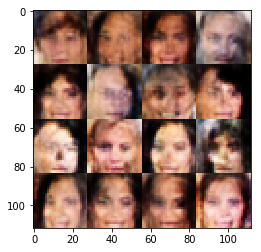

Epoch 3/5... Discriminator Loss: 1.4052... Generator Loss: 1.0704
Epoch 3/5... Discriminator Loss: 1.8003... Generator Loss: 0.6218
Epoch 3/5... Discriminator Loss: 1.6575... Generator Loss: 0.4826
Epoch 3/5... Discriminator Loss: 1.3305... Generator Loss: 1.1448
Epoch 3/5... Discriminator Loss: 1.2850... Generator Loss: 0.8176
Epoch 3/5... Discriminator Loss: 1.6636... Generator Loss: 0.8986
Epoch 3/5... Discriminator Loss: 1.5416... Generator Loss: 0.6224
Epoch 3/5... Discriminator Loss: 1.5881... Generator Loss: 0.6333
Epoch 3/5... Discriminator Loss: 1.2268... Generator Loss: 1.3228
Epoch 3/5... Discriminator Loss: 1.2056... Generator Loss: 1.0514


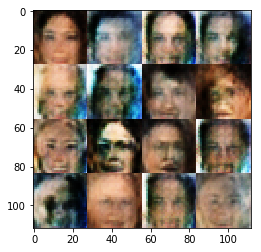

Epoch 3/5... Discriminator Loss: 1.5769... Generator Loss: 0.6875
Epoch 3/5... Discriminator Loss: 1.5030... Generator Loss: 0.6462
Epoch 3/5... Discriminator Loss: 1.5924... Generator Loss: 1.2596
Epoch 3/5... Discriminator Loss: 1.4846... Generator Loss: 0.8723
Epoch 3/5... Discriminator Loss: 1.4189... Generator Loss: 0.7939
Epoch 3/5... Discriminator Loss: 1.4444... Generator Loss: 1.1429
Epoch 3/5... Discriminator Loss: 1.3848... Generator Loss: 0.8723
Epoch 3/5... Discriminator Loss: 1.2167... Generator Loss: 1.1384
Epoch 3/5... Discriminator Loss: 1.2722... Generator Loss: 0.9271
Epoch 3/5... Discriminator Loss: 1.6109... Generator Loss: 0.5221


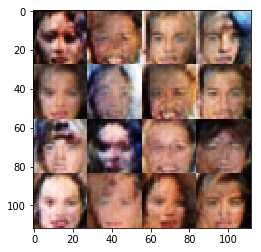

Epoch 3/5... Discriminator Loss: 1.5729... Generator Loss: 1.0505
Epoch 3/5... Discriminator Loss: 1.2141... Generator Loss: 0.9481
Epoch 3/5... Discriminator Loss: 1.4095... Generator Loss: 0.7939
Epoch 3/5... Discriminator Loss: 1.2774... Generator Loss: 0.7706
Epoch 3/5... Discriminator Loss: 1.5498... Generator Loss: 1.2185
Epoch 3/5... Discriminator Loss: 1.2352... Generator Loss: 0.9001
Epoch 4/5... Discriminator Loss: 1.7725... Generator Loss: 0.4671
Epoch 4/5... Discriminator Loss: 1.3544... Generator Loss: 1.0057
Epoch 4/5... Discriminator Loss: 1.3788... Generator Loss: 1.0314
Epoch 4/5... Discriminator Loss: 1.3342... Generator Loss: 0.9010


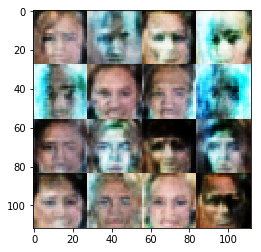

Epoch 4/5... Discriminator Loss: 1.6386... Generator Loss: 0.5127
Epoch 4/5... Discriminator Loss: 1.2615... Generator Loss: 1.0395
Epoch 4/5... Discriminator Loss: 1.2865... Generator Loss: 1.1343
Epoch 4/5... Discriminator Loss: 1.6437... Generator Loss: 0.5300
Epoch 4/5... Discriminator Loss: 1.6339... Generator Loss: 0.5509
Epoch 4/5... Discriminator Loss: 1.3203... Generator Loss: 0.9209
Epoch 4/5... Discriminator Loss: 1.6361... Generator Loss: 0.6638
Epoch 4/5... Discriminator Loss: 1.3789... Generator Loss: 1.2923
Epoch 4/5... Discriminator Loss: 1.7445... Generator Loss: 0.5577
Epoch 4/5... Discriminator Loss: 1.4570... Generator Loss: 0.8209


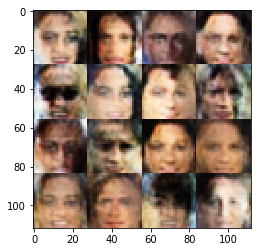

Epoch 4/5... Discriminator Loss: 1.5097... Generator Loss: 0.8247
Epoch 4/5... Discriminator Loss: 1.4434... Generator Loss: 0.8999
Epoch 4/5... Discriminator Loss: 1.4700... Generator Loss: 0.7581
Epoch 4/5... Discriminator Loss: 1.2867... Generator Loss: 0.9773
Epoch 4/5... Discriminator Loss: 1.5944... Generator Loss: 0.9269
Epoch 4/5... Discriminator Loss: 1.4128... Generator Loss: 1.1294
Epoch 4/5... Discriminator Loss: 1.4024... Generator Loss: 0.7233
Epoch 4/5... Discriminator Loss: 1.6940... Generator Loss: 0.6347
Epoch 4/5... Discriminator Loss: 1.4679... Generator Loss: 1.0745
Epoch 4/5... Discriminator Loss: 1.6950... Generator Loss: 0.4862


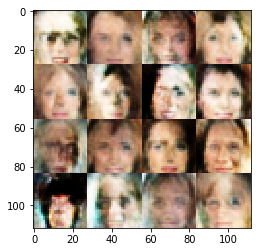

Epoch 4/5... Discriminator Loss: 1.5066... Generator Loss: 0.7145
Epoch 4/5... Discriminator Loss: 1.8123... Generator Loss: 0.5039
Epoch 4/5... Discriminator Loss: 1.4678... Generator Loss: 0.7858
Epoch 4/5... Discriminator Loss: 1.7286... Generator Loss: 0.6077
Epoch 4/5... Discriminator Loss: 1.3916... Generator Loss: 0.8917
Epoch 4/5... Discriminator Loss: 1.3405... Generator Loss: 0.7549
Epoch 4/5... Discriminator Loss: 1.5762... Generator Loss: 0.7456
Epoch 4/5... Discriminator Loss: 1.5336... Generator Loss: 0.9234
Epoch 4/5... Discriminator Loss: 1.6080... Generator Loss: 0.8359
Epoch 4/5... Discriminator Loss: 1.4970... Generator Loss: 0.7799


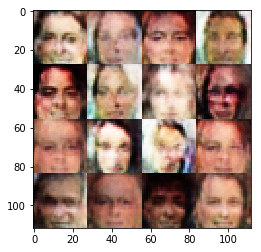

Epoch 4/5... Discriminator Loss: 1.1235... Generator Loss: 1.1950
Epoch 4/5... Discriminator Loss: 1.3816... Generator Loss: 0.9025
Epoch 4/5... Discriminator Loss: 1.2537... Generator Loss: 0.8009
Epoch 4/5... Discriminator Loss: 1.3239... Generator Loss: 0.9518
Epoch 4/5... Discriminator Loss: 1.5050... Generator Loss: 1.0379
Epoch 4/5... Discriminator Loss: 1.5836... Generator Loss: 0.8958
Epoch 4/5... Discriminator Loss: 1.4415... Generator Loss: 1.1141
Epoch 4/5... Discriminator Loss: 1.4380... Generator Loss: 1.0834
Epoch 4/5... Discriminator Loss: 1.3698... Generator Loss: 0.8925
Epoch 4/5... Discriminator Loss: 1.4471... Generator Loss: 0.9040


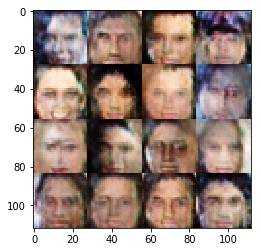

Epoch 4/5... Discriminator Loss: 1.3130... Generator Loss: 0.7299
Epoch 4/5... Discriminator Loss: 1.5078... Generator Loss: 0.6762
Epoch 4/5... Discriminator Loss: 1.5117... Generator Loss: 0.7357
Epoch 4/5... Discriminator Loss: 1.3778... Generator Loss: 0.9053
Epoch 4/5... Discriminator Loss: 1.4549... Generator Loss: 0.7651
Epoch 4/5... Discriminator Loss: 1.3315... Generator Loss: 1.0603
Epoch 4/5... Discriminator Loss: 1.5094... Generator Loss: 1.5196
Epoch 4/5... Discriminator Loss: 1.3475... Generator Loss: 0.9847
Epoch 4/5... Discriminator Loss: 1.4364... Generator Loss: 0.8588
Epoch 4/5... Discriminator Loss: 1.4254... Generator Loss: 0.9967


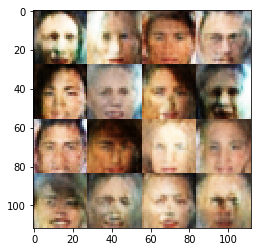

Epoch 4/5... Discriminator Loss: 1.3663... Generator Loss: 0.6703
Epoch 4/5... Discriminator Loss: 1.4869... Generator Loss: 0.8178
Epoch 4/5... Discriminator Loss: 1.5594... Generator Loss: 0.6335
Epoch 4/5... Discriminator Loss: 1.4230... Generator Loss: 0.6247
Epoch 4/5... Discriminator Loss: 1.6445... Generator Loss: 0.9689
Epoch 4/5... Discriminator Loss: 1.2844... Generator Loss: 0.9365
Epoch 4/5... Discriminator Loss: 1.4417... Generator Loss: 1.2910
Epoch 4/5... Discriminator Loss: 1.5853... Generator Loss: 0.6695
Epoch 4/5... Discriminator Loss: 1.3705... Generator Loss: 0.9300
Epoch 4/5... Discriminator Loss: 1.4866... Generator Loss: 1.0946


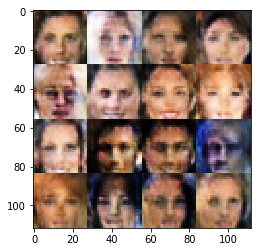

Epoch 4/5... Discriminator Loss: 1.3118... Generator Loss: 0.9796
Epoch 4/5... Discriminator Loss: 1.4571... Generator Loss: 0.8629
Epoch 4/5... Discriminator Loss: 1.2178... Generator Loss: 0.9913
Epoch 4/5... Discriminator Loss: 1.5297... Generator Loss: 0.5701
Epoch 4/5... Discriminator Loss: 1.7024... Generator Loss: 0.5942
Epoch 4/5... Discriminator Loss: 1.5068... Generator Loss: 1.0629
Epoch 4/5... Discriminator Loss: 1.6259... Generator Loss: 0.9407
Epoch 4/5... Discriminator Loss: 1.2577... Generator Loss: 0.9018
Epoch 4/5... Discriminator Loss: 1.5063... Generator Loss: 0.8500
Epoch 4/5... Discriminator Loss: 1.4132... Generator Loss: 0.9904


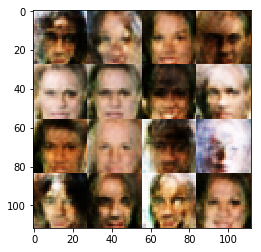

Epoch 4/5... Discriminator Loss: 1.4341... Generator Loss: 0.9250
Epoch 4/5... Discriminator Loss: 1.3375... Generator Loss: 0.8591
Epoch 4/5... Discriminator Loss: 1.3711... Generator Loss: 0.9857
Epoch 4/5... Discriminator Loss: 1.4800... Generator Loss: 0.9003
Epoch 4/5... Discriminator Loss: 1.9793... Generator Loss: 0.5775
Epoch 4/5... Discriminator Loss: 1.2229... Generator Loss: 0.9434
Epoch 4/5... Discriminator Loss: 1.3855... Generator Loss: 0.8179
Epoch 4/5... Discriminator Loss: 1.2112... Generator Loss: 1.3140
Epoch 4/5... Discriminator Loss: 1.3910... Generator Loss: 1.0295
Epoch 4/5... Discriminator Loss: 1.4379... Generator Loss: 0.9741


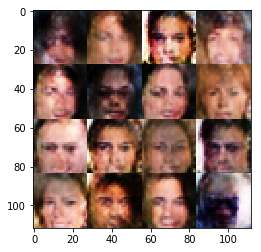

Epoch 4/5... Discriminator Loss: 1.3329... Generator Loss: 0.6806
Epoch 4/5... Discriminator Loss: 1.2056... Generator Loss: 0.8331
Epoch 4/5... Discriminator Loss: 1.3396... Generator Loss: 0.8233
Epoch 4/5... Discriminator Loss: 1.4564... Generator Loss: 0.6237
Epoch 4/5... Discriminator Loss: 1.6690... Generator Loss: 0.6468
Epoch 4/5... Discriminator Loss: 1.4725... Generator Loss: 0.8876
Epoch 4/5... Discriminator Loss: 1.3303... Generator Loss: 1.0993
Epoch 4/5... Discriminator Loss: 1.4665... Generator Loss: 0.7325
Epoch 4/5... Discriminator Loss: 1.1759... Generator Loss: 1.1417
Epoch 4/5... Discriminator Loss: 1.4408... Generator Loss: 0.6464


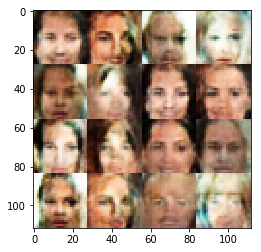

Epoch 4/5... Discriminator Loss: 1.4440... Generator Loss: 0.7571
Epoch 4/5... Discriminator Loss: 1.4723... Generator Loss: 0.7024
Epoch 4/5... Discriminator Loss: 1.4239... Generator Loss: 0.8234
Epoch 4/5... Discriminator Loss: 1.3611... Generator Loss: 1.0251
Epoch 4/5... Discriminator Loss: 1.8171... Generator Loss: 0.6361
Epoch 4/5... Discriminator Loss: 1.4898... Generator Loss: 0.9109
Epoch 4/5... Discriminator Loss: 1.3263... Generator Loss: 0.8020
Epoch 4/5... Discriminator Loss: 1.4182... Generator Loss: 0.9534
Epoch 4/5... Discriminator Loss: 1.4275... Generator Loss: 1.1377
Epoch 4/5... Discriminator Loss: 1.4893... Generator Loss: 0.7488


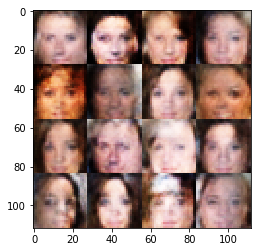

Epoch 4/5... Discriminator Loss: 1.6826... Generator Loss: 0.9965
Epoch 4/5... Discriminator Loss: 1.3098... Generator Loss: 0.6159


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。